In [55]:
%matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split


# Raw data

In [2]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Enriching

In [113]:
raw['shot_distance_squared'] = raw['shot_distance'] * raw['shot_distance']

# Splitting test data

In [114]:
use_rows = raw['shot_made_flag'].notnull()
usage_set = raw[use_rows]
compete_set = raw[pandas.isna(raw['shot_made_flag'])]

# FIXME: test with different test/train splits
seed = 1
test_size = 0.3
training, testing = train_test_split(usage_set, test_size=test_size, random_state=seed)

assert compete_set['shot_id'].shape[0] == 5000
assert compete_set['shot_id'].values[0] == 4
assert compete_set['shot_id'].values[-1] == 30693

training[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id,shot_distance_squared
5862,Layup,0,0,4,1,0,2004-05,34,0,1.0,2PT Field Goal,Center(C),Less Than 8 ft.,DET,6983,0
20287,Jump Shot,108,5,8,2,0,1997-98,34,10,1.0,2PT Field Goal,Right Side(R),8-16 ft.,DAL,24213,100


# Data / feature exploration

count    14487.000000
mean        13.507075
std          9.335624
min          0.000000
25%          5.000000
50%         15.000000
75%         21.000000
max         79.000000
Name: shot_distance, dtype: float64


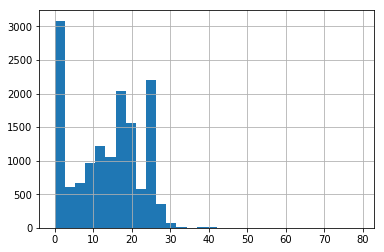

In [6]:
print(training['shot_distance'].describe())

training['shot_distance'].hist(bins=30)

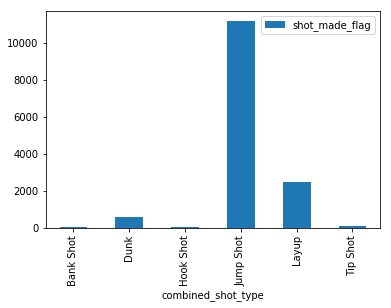

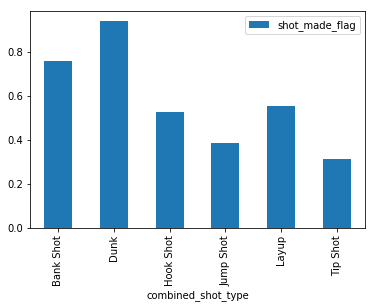

In [34]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

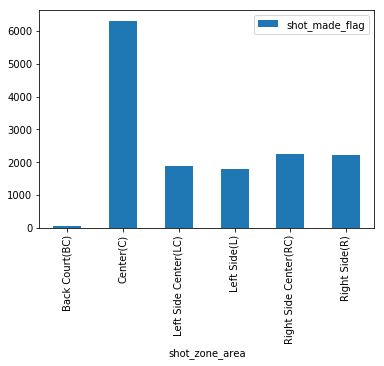

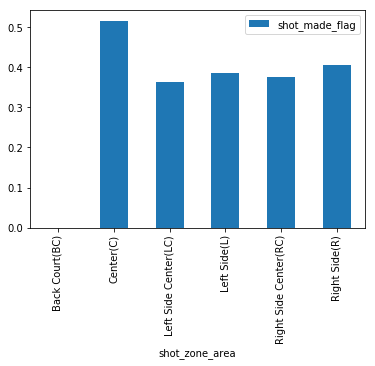

In [37]:
training.groupby(['shot_zone_area']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['shot_zone_area']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

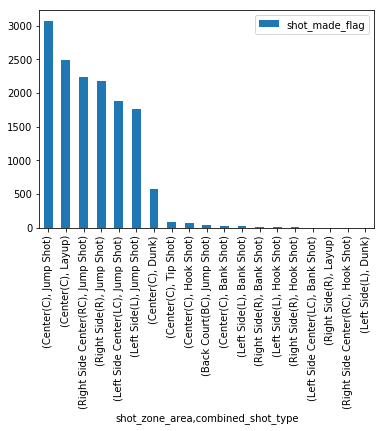

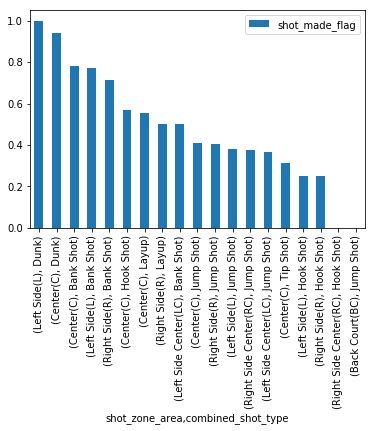

In [52]:
shot_area_type = training.groupby(['shot_zone_area', 'combined_shot_type'])
shot_area_type.agg({'shot_made_flag': 'count'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')
shot_area_type.agg({'shot_made_flag': 'mean'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')

In [50]:
training['season'].unique()

array(['2004-05', '1997-98', '2006-07', '2012-13', '2003-04', '2005-06',
       '2000-01', '2009-10', '2002-03', '2007-08', '2015-16', '2010-11',
       '1998-99', '2001-02', '1999-00', '2013-14', '2008-09', '2011-12',
       '1996-97', '2014-15'], dtype=object)

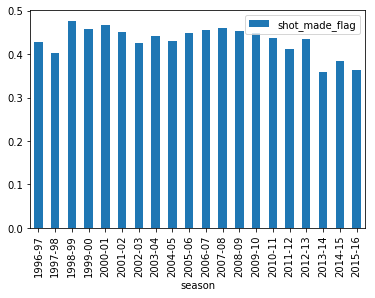

In [36]:
training.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [11]:
training['opponent'].unique()

array(['DET', 'DAL', 'HOU', 'LAC', 'SAC', 'CHA', 'GSW', 'UTA', 'MIL',
       'IND', 'POR', 'NYK', 'NOH', 'VAN', 'NOP', 'MEM', 'OKC', 'MIN',
       'ORL', 'NJN', 'DEN', 'CLE', 'MIA', 'SEA', 'CHI', 'SAS', 'BOS',
       'PHX', 'WAS', 'TOR', 'PHI', 'ATL', 'BKN'], dtype=object)

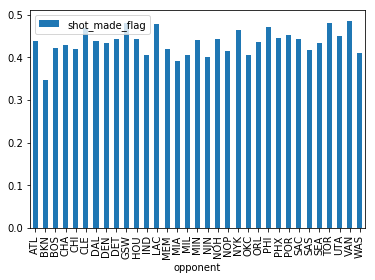

In [30]:
training.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

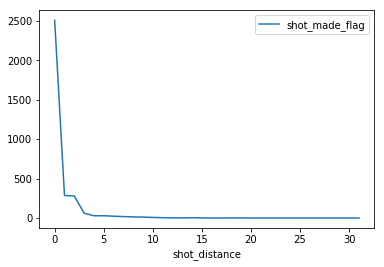

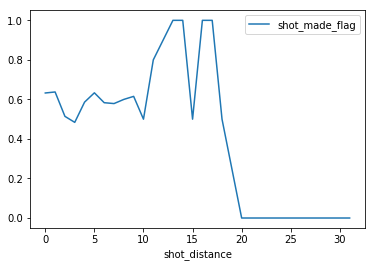

In [112]:
training[training['combined_shot_type'] != 'Jump Shot'].groupby(['shot_distance']).agg({'shot_made_flag': 'count'}).plot()
training[training['combined_shot_type'] != 'Jump Shot'].groupby(['shot_distance']).agg({'shot_made_flag': 'mean'}).plot()

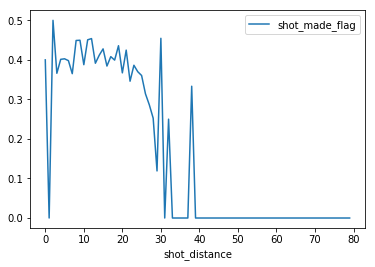

In [118]:
training[training['combined_shot_type'] == 'Jump Shot'].groupby(['shot_distance']).agg({'shot_made_flag': 'mean'}).plot()

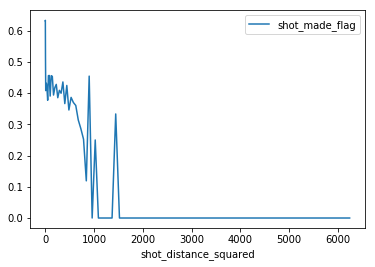

In [121]:
training[training['combined_shot_type'] != '2Jump Shot'].groupby(['shot_distance_squared']).agg({'shot_made_flag': 'mean'}).plot()

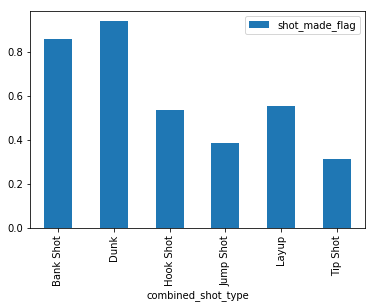

In [95]:
training[training['shot_distance'] < 5.0].groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [107]:
pandas.cut(training['shot_distance'], bins=10).value_counts()

(-0.079, 7.9]    4359
(15.8, 23.7]     4182
(7.9, 15.8]      3235
(23.7, 31.6]     2633
(31.6, 39.5]       30
(39.5, 47.4]       20
(55.3, 63.2]       10
(47.4, 55.3]        8
(63.2, 71.1]        7
(71.1, 79.0]        3
Name: shot_distance, dtype: int64

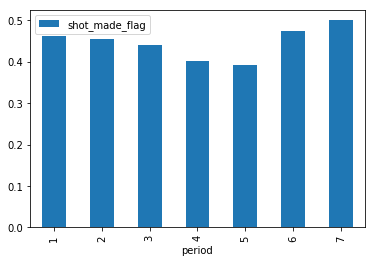

In [108]:
training.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

# Model

In [122]:
labelencoder = sklearn.preprocessing.OneHotEncoder()

X = training['shot_distance_squared'].reshape(-1, 1)
Y = labelencoder.fit_transform(training['shot_made_flag'].reshape(-1,1)).todense()

model = PLSRegression(n_components=1)
model.fit(X, Y)

X_test = testing['shot_distance_squared'].reshape(-1, 1)
Y_test = testing['shot_made_flag'].astype(numpy.bool)
Y_pred = model.predict(X_test).argmax(axis=1)

Y_pred.shape, Y_test.shape
Y_pred[0:10], Y_test.values[0:10]

# classification accuracy
a = sklearn.metrics.accuracy_score(Y_test, Y_pred)
a

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


0.5985507246376811

In [123]:
X_comp = compete_set['shot_distance_squared'].reshape(-1, 1)
Y_comp = model.predict(X_comp).argmax(axis=-1)

out = compete_set.copy()
out['shot_made_flag'] = Y_comp.astype(numpy.float)
out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


### Features

* Shot distance
* Shot type. Categorical
* Location on court. How is organized?
* Points
* Opponent
* Minutes/seconds remaining. In the period? (4x12 min)
* Period
* Season


### Target

Where predictions are removed (nAn) is the validation data

Is there any pattern here that can be exploited?


## Modelling

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR

TODO

* check existing Kaggle competitions, good performing algorithms
* setup sklearn pipeline
* setup Grid search
* format Kaggle submission

Trips & tricks

* LabelEncoder. Categoical data. Ordinal (orderable) versus nominal (not orderable)
